In [1]:
%pip install langchain langgraph pandas python-dotenv duckdb openai

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install --upgrade openai

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [1]:
from typing import TypedDict, Optional, Dict, List, Union
import logging
import json
import os
import pandas as pd
import duckdb
from openai import OpenAI
from langchain.tools import tool
from langgraph.graph import StateGraph, END
from langchain_core.messages import SystemMessage, HumanMessage
from langgraph.checkpoint.memory import MemorySaver

from dotenv import load_dotenv

_ = load_dotenv()

/Users/jeny/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
QUERY_GENERATION_PROMPT = """You are an Excel analysis expert that generates SQL or Pandas queries to analyze data.

IF preview_data IS NOT available:
  1. Call load_preview_data to understand Excel content, columns and types
  2. Return function call for load_preview_data

ELSE IF preview_data IS available:
  1. Review the preview_data structure and types
  2. Evaluate user_input complexity and generate appropriate query. **VERY IMPORTANT -** Check the **Data Analysis Rules**, **DuckDB SQL Rules* and **Pandas Rules* BEFORE generating a query.
  3. Decide and return a function call:
      - Call simple_dataframe_query for Pandas queries.
      - Call complex_duckdb_query for DuckDB queries.

Tools Available:
1. load_preview_data: To read the excel and preview its columns and data types. 
   Input: {"file_name": "example.xlsx"}

2. simple_dataframe_query: For ANY operation that can be easily done with Pandas
   Input: {"file_name": "example.xlsx", "query": "df.query('column > 0').count()"}
   
3. complex_duckdb_query: For complex SQL operations (GROUP BY, aggregations). ONLY for operations that cannot be done easily in Pandas
   Input: {"file_name": "example.xlsx", "query": "SELECT * FROM data"}

Data Analysis Rules:
1. NULL/Empty Value Handling:
   - When calculating averages across columns:
     * Sum only non-null values
     * Divide by count of non-null values
   - Use CAST(column IS NOT NULL AS INTEGER) to count valid values
   - Always use NULLIF for safe division
   - Handle NULLs before aggregating

2. Query Structure Requirements:
   - Break complex calculations into CTEs
   - Calculate row-level metrics first
   - Then group and aggregate
   - Include validation counts
   - Example:
     WITH base_metrics AS (
       SELECT *,
         COALESCE(value, 0) as clean_value,
         CAST(value IS NOT NULL AS INTEGER) as valid_count
     ),
     row_metrics AS (
       SELECT *,
         SUM(clean_value) / NULLIF(SUM(valid_count), 0) as row_avg
     FROM base_metrics
     GROUP BY row_id
     )

3. DuckDB SQL Rules:
   - Quote columns with spaces: "Column Name"
   - Include all non-aggregated columns in GROUP BY
   - Reference table as 'data'
   - Use proper type casting
   - Add range checks for numeric operations

4. Pandas Rules:
   - Reference DataFrame as 'df'
   - **Numpy quersies are NOT ALLOWED! Only simple Pandas queries are ALLOWED**
   - Handle NULLs with fillna()
   - Use proper data types

Pandas Query Patterns - USE THESE:
✓ Filtering: df.query('column == value')
✓ Counting: df.query('condition').count()
✓ Aggregation: df.query('condition').agg({'col': 'mean'})
✓ Multiple conditions: df.query('col1 > 0 and col2 < 10')

NEVER USE THESE PATTERNS:
✗ df[df['column'] == value]  # No bracket filtering
✗ np.any(), np.all()         # No numpy operations
✗ df.loc[], df.iloc[]        # Avoid direct indexing

"""

In [3]:
VALIDATE_QUERY_PROMPT = """You are an AI assistant validating and improving queries for Excel data analysis.

IF query_result contains error then:
  1. Analyse the error and given user input: `llm_prompt`, failed query: `query` and `query_result`, generate a new correct query. 
      - **WHEN query_result contains **error** related to Pandas query execution, then you MUST generate SQL query, given the llm_prompt!**
  2. Decide and return a function call:
      - Call simple_dataframe_query for Pandas queries.
      - Call complex_duckdb_query for DuckDB queries.

ELSE IF NO error in query_result then:
  1. Verify the `query` agains the `llm_prompt` and ensure that it correctly answers user input.
  2. If query corrections are needed to correctly answer the user question then generate a new correct query 
  3. Decide and return a function call:
      - Call simple_dataframe_query for Pandas queries.
      - Call complex_duckdb_query for DuckDB queries.

Tools Available:
2. simple_dataframe_query: For ANY operation that can be easily done with Pandas
   Input: {"file_name": "example.xlsx", "query": "df.query('column > 0').count()"}
   
3. complex_duckdb_query: For complex SQL operations (GROUP BY, aggregations). ONLY for operations that cannot be done easily in Pandas
   Input: {"file_name": "example.xlsx", "query": "SELECT * FROM data"}

**SQL Query Validation:**
1. NULL Handling:
   - Verify NULLs are properly excluded from calculations
   - Check for NULLIF in divisions
   - Confirm COALESCE usage for NULL defaults
   - Validate empty value handling in aggregations

2. Aggregation Validation:
   - All non-aggregated columns must be in GROUP BY
   - Verify aggregation functions match business logic
   - Check percentage calculations sum correctly
   - Validate count metrics against row counts

3. Query Structure:
   - Use CTEs for complex calculations
   - Break operations into logical steps:
     * Clean and validate data
     * Calculate row-level metrics
     * Perform grouping and aggregation
   - Include data validation steps
   - Add range checks for numeric operations

4. Error Prevention:
   - Add NULLIF for division operations
   - Include proper type casting
   - Validate numeric operations
   - Handle edge cases explicitly
   
5. Complex Calculation Patterns:
   WITH data_validation AS (
     -- Clean and validate input data
   ),
   row_metrics AS (
     -- Calculate row-level statistics
   ),
   aggregated_results AS (
     -- Perform final aggregations
   )
"""

In [13]:
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

class AgentState(TypedDict):
    user_input: str
    query: Optional[str]
    file_name: str
    preview_data: Optional[Dict[str, List]]
    query_result: Optional[Dict]
    llm_prompt: Optional[str]
    tool: Optional[str]
    iterations_count: int
    error: Optional[str]
    messages: List[Dict]

def load_preview_data(file_name: str) -> dict:
    try:
        if not file_name:
            raise ValueError("File name must be provided")
        
        df = pd.read_excel(os.path.join(os.getcwd(), file_name), nrows=1)
        df = df.replace(r'^\s*$', None, regex=True)
        df = df.replace(['nan', 'NaN', 'null'], None)
        df = df.where(pd.notnull(df), None)
        
        return {
            "columns": df.columns.tolist(),
            "dtypes": df.dtypes.astype(str).to_dict(),
            "sample_rows": df.to_dict(orient="records")
        }
    except Exception as e:
        return {"error": f"Failed to examine Excel structure: {str(e)}"}

def complex_duckdb_query(file_name: str, query: str) -> dict:
    try:
        df = pd.read_excel(os.path.join(os.getcwd(), file_name))
        df = df.replace(r'^\s*$', None, regex=True)
        df = df.replace(['nan', 'NaN', 'null'], None)
        df = df.where(pd.notnull(df), None)
        
        con = duckdb.connect()
        con.register("data", df)
        
        result = con.execute(query).fetchdf()
        if result is None:
            return {"result": None}
        
        result = result.replace([float('inf'), -float('inf')], None)
        result = result.where(pd.notna(result), None)
        
        return {
            "result": {
                "columns": result.columns.tolist(),
                "rows": result.to_dict(orient="records")
            }
        }
    except Exception as e:
        return {"error": f"DuckDB query error: {str(e)}"}
    finally:
        if 'con' in locals():
            con.close()

def simple_dataframe_query(file_name: str, query: str) -> dict:
    try:
        df = pd.read_excel(os.path.join(os.getcwd(), file_name))
        df = df.replace(r'^\s*$', None, regex=True)
        df = df.replace(['nan', 'NaN', 'null'], None)
        df = df.where(pd.notnull(df), None)
        
        safe_globals = {
            "df": df,
            "pd": pd,
            "__builtins__": {}
        }
        
        result = eval(query, safe_globals, {})
        
        if isinstance(result, pd.DataFrame):
            result = result.replace([float('inf'), -float('inf')], None)
            result = result.where(pd.notna(result), None)
            return {
                "result": {
                    "type": "DataFrame",
                    "columns": result.columns.tolist(),
                    "rows": result.to_dict(orient="records")
                }
            }
        elif isinstance(result, pd.Series):
            result = result.replace([float('inf'), -float('inf')], None)
            result = result.where(pd.notna(result), None)
            return {
                "result": {
                    "type": "Series",
                    "name": result.name,
                    "values": result.tolist()
                }
            }
        else:
            return {
                "result": {
                    "type": "scalar",
                    "value": None if pd.isna(result) else result
                }
            }
    except Exception as e:
        return {"error": f"Error executing query: {str(e)}"}

TOOLS = [
    {
        "type": "function",
        "function": {
            "name": "load_preview_data",
            "description": "Examine Excel file structure",
            "parameters": {
                "type": "object",
                "properties": {
                    "file_name": {"type": "string"}
                },
                "required": ["file_name"]
            }
        }
    },
    {
        "type": "function",
        "function": {
            "name": "simple_dataframe_query",
            "description": "Execute simple Pandas operations",
            "parameters": {
                "type": "object",
                "properties": {
                    "file_name": {"type": "string"},
                    "query": {"type": "string"}
                },
                "required": ["file_name", "query"]
            }
        }
    },
    {
        "type": "function",
        "function": {
            "name": "complex_duckdb_query",
            "description": "Execute complex SQL operations",
            "parameters": {
                "type": "object",
                "properties": {
                    "file_name": {"type": "string"},
                    "query": {"type": "string"}
                },
                "required": ["file_name", "query"]
            }
        }
    }
]

def execute_function(name: str, args: dict, state: AgentState) -> dict:
   try:
       function_map = {
           "load_preview_data": load_preview_data,
           "simple_dataframe_query": simple_dataframe_query,
           "complex_duckdb_query": complex_duckdb_query
       }
       result = function_map[name](**args)
       
       if isinstance(result, dict) and "error" in result:
           state["error"] = result["error"]
           
       return result
       
   except Exception as e:
       state["error"] = str(e)
       return {"error": str(e)}

def generate_and_execute_query_node(state: AgentState) -> AgentState:
    client = OpenAI()
    try:
        if not state.get("file_name") or not state.get("user_input"):
            raise ValueError("Missing required fields: file_name or user_input")

        state["iterations_count"] = state.get("iterations_count", 0) + 1

        if "messages" not in state:
            state["messages"] = []
            
        messages = [
            {"role": "system", "content": QUERY_GENERATION_PROMPT},
            {"role": "user", "content": f"Preview data: {state.get('preview_data')}\nFile: {state['file_name']}\nTask: {state['user_input']}"}
        ]

        print(f"{state.get('iterations_count')} :: Generate Query Node - MESSAGES -> \n###############################\n{messages}\n################################")
        
        response = client.chat.completions.create(
            model="gpt-4o",
            messages=messages,
            tools=TOOLS,
            tool_choice="auto", #if must call then use: required
            parallel_tool_calls=True, # Defaults to true!!!!!!!!!!! 
            temperature=0,
        )

        print(f"{state.get('iterations_count')} :: Generate Query Node - LLM RESPONSE -> \n###############################\n{response.choices[0].message}\n################################")
        
        message = response.choices[0].message
        if not message.tool_calls:
            raise ValueError("No tool calls in response")
            
        tool_call = message.tool_calls[0]
        args = json.loads(tool_call.function.arguments)
        
        if "file_name" not in args:
            args["file_name"] = state["file_name"]
            
        result = execute_function(tool_call.function.name, args, state)
        
        state.update({
            "tool": tool_call.function.name,
            "preview_data": result if tool_call.function.name == "load_preview_data" else state.get("preview_data"),
            "query": args.get("query"),
            "query_result": result if tool_call.function.name != "load_preview_data" else None,
            "llm_prompt": state["user_input"][0] if isinstance(state["user_input"], tuple) else state["user_input"],
            "messages": messages + [
                {"role": "assistant", "content": message.content, "tool_calls": [{"id": tool_call.id, "type": "function", "function": {"name": tool_call.function.name, "arguments": json.dumps(args)}}]},
                {"role": "tool", "tool_call_id": tool_call.id, "name": tool_call.function.name, "content": json.dumps(result)}
            ]
        })

        print(f"{state.get('iterations_count')} :: Generate Query Node - STATE -> \n###############################\n{json.dumps(state, indent=2)}\n################################")
        return state
        
    except Exception as e:
        logger.error(f"Error in validate_and_execute_query_node: {str(e)}")
        state["error"] = str(e)
        return state
        

def validate_and_execute_query_node(state: AgentState) -> AgentState:
    state["iterations_count"] = state.get("iterations_count", 0) + 1
    
    # # Add function call loop prevention
    # function_calls = {}
    # tool_name = state.get("tool")  # Get the tool name from state
        
    # # Track function calls per iteration
    # if tool_name not in function_calls:
    #     function_calls[tool_name] = 0
    # function_calls[tool_name] += 1
    
    # if function_calls[tool_name] >= 3:
    #     state["error"] = f"Too many calls to {tool_name}"
    #     return state

    function_calls = {}
    tool_name = state.get("tool")
    
    if tool_name:
        function_calls[tool_name] = function_calls.get(tool_name, 0) + 1  # Safe way to increment
    
    # Prevent excessive tool calls
    if function_calls.get(tool_name, 0) >= 3:
        state["error"] = f"Too many calls to {tool_name}"
        return state
    
    client = OpenAI()
    
    try:
        if state.get("error"):
            return state
            
        if not state.get("query") or not state.get("tool"):
            state["error"] = "Missing query or tool selection"
            return state

        messages = state["messages"] + [
            {"role": "system", "content": VALIDATE_QUERY_PROMPT}, 
            {"role": "user", "content": f"Preview data: {state.get('preview_data')}\nLLM query: {state.get('query')}\nUser query: {state['llm_prompt']}\nExecution result: {state.get('query_result')}"}
        ]

        print(f"{state.get('iterations_count')} :: Validate Query Node - MESSAGES -> \n###############################\n{messages}\n################################")
        
        response = client.chat.completions.create(
            model="gpt-4o",
            messages=messages,
            tools=TOOLS,
            tool_choice="auto",
            parallel_tool_calls=False,
            temperature=0
        )

        print(f"{state.get('iterations_count')} :: Validate Query Node - LLM RESPONSE -> \n###############################\n{response.choices[0].message}\n################################")
        
        message = response.choices[0].message
        
        if not message.tool_calls:
            raise ValueError("No tool calls in response, hence the validation passed successfully!")

        # if not message.tool_calls:
        #     print(f"{state.get('iterations_count')} :: No further tool calls, validation complete.")
        #     state["messages"].append(
        #         {"role": "assistant", "content": message.content}
        #     )
        #     return state  # Proceed without executing any tool
            
        tool_call = message.tool_calls[0]
        args = json.loads(tool_call.function.arguments)
        
        if "file_name" not in args:
            args["file_name"] = state["file_name"]
            
        result = execute_function(tool_call.function.name, args, state)
        
        state["query_result"] = result
        
        state["messages"].extend([
            {
                "role": "assistant",
                "content": message.content,
                "tool_calls": [{"id": tool_call.id, "type": "function", "function": {"name": tool_call.function.name, "arguments": json.dumps(args)}}]
            },
            {
                "role": "tool",
                "tool_call_id": tool_call.id,
                "name": tool_call.function.name,
                "content": json.dumps(result)
            }
        ])

        print(f"{state.get('iterations_count')} :: Validate Query Node - STATE ->\n###############################\n{json.dumps(state, indent=2)}\n################################")
        return state
        
    except Exception as e:
        logger.error(f"Error in validate_and_execute_query_node: {str(e)}")
        state["error"] = str(e)
        return state

def next_step(state: AgentState) -> str:
    # Check iterations first
    if state.get("iterations_count", 0) > 7:
        return END
    
    if state.get("preview_data") is None:
        return "generate_and_execute_query_node"
        
    if state.get("query") is None:
        return "generate_and_execute_query_node"

    if state.get("query_result") is None or (
        isinstance(state.get("query_result"), dict) and 
        state.get("query_result", {}).get("error")
    ):
        return "validate_and_execute_query_node"
        
    return END

# Comment the above next_step and uncomment this one if you want to force the validation step!
# def next_step(state: AgentState) -> str:
#     # Check iteration limits first
#     if state.get("iterations_count", 0) > 7:
#         return END

#     # Always ensure state updates before progressing
#     if state.get("preview_data") is None:
#         return "generate_and_execute_query_node"
        
#     if state.get("query") is None:
#         return "generate_and_execute_query_node"
    
#     # Ensure that after query generation, validation always happens
#     if state.get("query_result") is None or isinstance(state.get("query_result"), dict):
#         return "validate_and_execute_query_node"
        
#     return "validate_and_execute_query_node"  # Force validation step


def create_agent_graph(memory: Optional[MemorySaver] = None) -> StateGraph:
    if memory is None:
        memory = MemorySaver()
    
    builder = StateGraph(AgentState)
    builder.add_node("generate_and_execute_query_node", generate_and_execute_query_node)
    builder.add_node("validate_and_execute_query_node", validate_and_execute_query_node)
    
    builder.add_conditional_edges(
        "generate_and_execute_query_node",
        next_step,
        {
            "generate_and_execute_query_node": "generate_and_execute_query_node", 
            "validate_and_execute_query_node": "validate_and_execute_query_node",
            END: END # Comment this line to force the validation step
        }
    )
    
    builder.add_conditional_edges(
        "validate_and_execute_query_node",
        next_step,
        {
            "validate_and_execute_query_node": "validate_and_execute_query_node",
            END: END
        }
    )
    
    builder.set_entry_point("generate_and_execute_query_node")
    return builder.compile(checkpointer=memory)


def run_agent_query(user_input: str, file_name: str) -> Dict:
    memory = MemorySaver() 
    workflow = create_agent_graph(memory)
    thread = {"configurable": {"thread_id": "2"}}
    
    state: AgentState = {
        "user_input": user_input,
        "file_name": file_name,
        "iterations_count": 0,
        "query": None,
        "preview_data": None,
        "query_result": None,
        "llm_prompt": None,
        "tool": None,
        "error": None,
        "messages": []
    }

    # return workflow.invoke(state)
    return workflow.invoke(state, thread)

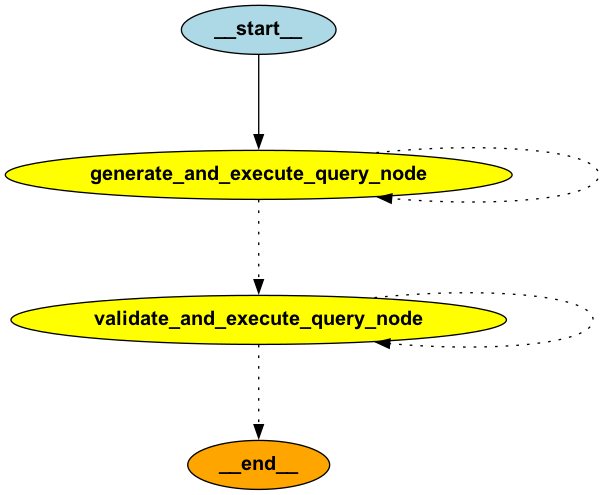

In [14]:
from IPython.display import Image
graph = create_agent_graph()
Image(graph.get_graph().draw_png())

In [15]:
# Run query

user_query = "Which ticker symbol have avg performance above 50% given the performance of a ticker symbol is spread in the months 1 through 13. Ignore empty months in the calculation!"
file_name = "ipo_data.xlsx"

final_state = run_agent_query(user_query, file_name)
print(json.dumps(final_state, indent=2))

# What percentage of the proposedTickerSymbols with proposed Price between 0 and 15.00 have average positive performance above 10%?
# "What percentage of the the TickerSymbols with proposed Price between 15.00 and 30.00 have average positive performance above 20%? List their ticker symbols."


1 :: Generate Query Node - MESSAGES -> 
###############################
[{'role': 'system', 'content': 'You are an Excel analysis expert that generates SQL or Pandas queries to analyze data.\n\nIF preview_data IS NOT available:\n  1. Call load_preview_data to understand Excel content, columns and types\n  2. Return function call for load_preview_data\n\nELSE IF preview_data IS available:\n  1. Review the preview_data structure and types\n  2. Evaluate user_input complexity and generate appropriate query. **VERY IMPORTANT -** Check the **Data Analysis Rules**, **DuckDB SQL Rules* and **Pandas Rules* BEFORE generating a query.\n  3. Decide and return a function call:\n      - Call simple_dataframe_query for Pandas queries.\n      - Call complex_duckdb_query for DuckDB queries.\n\nTools Available:\n1. load_preview_data: To read the excel and preview its columns and data types. \n   Input: {"file_name": "example.xlsx"}\n\n2. simple_dataframe_query: For ANY operation that can be easily done

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


1 :: Generate Query Node - LLM RESPONSE -> 
###############################
ChatCompletionMessage(content=None, refusal=None, role='assistant', audio=None, function_call=None, tool_calls=[ChatCompletionMessageToolCall(id='call_5dOFb81xpiUEiBTUU3LBV1XW', function=Function(arguments='{"file_name":"ipo_data.xlsx"}', name='load_preview_data'), type='function')])
################################
1 :: Generate Query Node - STATE -> 
###############################
{
  "user_input": "Which ticker symbol have avg performance above 50% given the performance of a ticker symbol is spread in the months 1 through 13. Ignore empty months in the calculation!",
  "query": null,
  "file_name": "ipo_data.xlsx",
  "preview_data": {
    "columns": [
      "dealID",
      "proposedTickerSymbol",
      "companyName",
      "proposedExchange",
      "proposedSharePrice",
      "sharesOffered",
      "pricedDate",
      "dollarValueOfSharesOffered",
      "dealStatus",
      "Industry",
      "CurrentPrice",


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


2 :: Generate Query Node - LLM RESPONSE -> 
###############################
ChatCompletionMessage(content='To determine which ticker symbols have an average performance above 50% based on the monthly performance data from "Month 1" to "Month 13", we need to calculate the average performance for each ticker symbol, ignoring any empty (NaN) values in the monthly columns. Given the complexity of handling multiple columns and ignoring NaN values, a DuckDB SQL query is appropriate for this task.\n\nHere\'s how we can structure the query:\n\n1. Calculate the sum of performances for each ticker symbol across the months, ignoring NaN values.\n2. Count the number of non-NaN months for each ticker symbol.\n3. Calculate the average performance by dividing the total performance by the count of non-NaN months.\n4. Filter the results to include only those ticker symbols with an average performance above 50%.\n\nLet\'s proceed with the DuckDB SQL query.', refusal=None, role='assistant', audio=None, f

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
ERROR:__main__:Error in validate_and_execute_query_node: No tool calls in response, hence the validation passed successfully!


3 :: Validate Query Node - LLM RESPONSE -> 
###############################
ChatCompletionMessage(content='The query executed successfully and returned the ticker symbols with an average performance above 50%, calculated over the months 1 through 13 while ignoring empty months. The query correctly follows the logic required to compute the average performance by summing the monthly performances and dividing by the count of non-null months.\n\nThe query is structured correctly, using CTEs to first calculate the total performance and valid month count, and then computing the average performance. The final selection filters for ticker symbols with an average performance greater than 50%.\n\nNo corrections are needed as the query meets the requirements specified in the user query.', refusal=None, role='assistant', audio=None, function_call=None, tool_calls=None)
################################
{
  "user_input": "Which ticker symbol have avg performance above 50% given the performance of a 

In [ ]:
# # Initialize exactly as in original
# from langchain_openai import ChatOpenAI
# model = ChatOpenAI(model="gpt-4o", temperature=0)
# model_with_tools = model.bind_tools(
#     [simple_dataframe_query, complex_duckdb_query],
#     parallel_tool_calls=False
# )

# # Run query
# user_query = "What percentage of the proposedTickerSymbol-s whit proposedSharePrice between 0 and 15.00 have average positive performance above 10%. The performance in percentage of each ticker is available in the months 1 through 13. Dont count empty months in the calculation.",
# file_name = "ipo_data.xlsx"
# run_agent_query(user_query, file_name)